In [7]:
import torch
import matplotlib.pyplot as plt

In [8]:
from final_quantization_kernel import quantize_rowwise_int4, dequantize_rowwise_int4
from asymmetric_quantization_kernel import quantize_rowwise_int4_asymmetric, dequantize_rowwise_int4_asymmetric
from group_quantization_kernel import quantize_groupwise_int4, dequantize_groupwise_int4

In [9]:
def plot_xy(x, y, x_label='X Axis', y_label='Y Axis', title='X vs Y Plot'):
    plt.figure(figsize=(5, 5))
    plt.plot(x, y, 'b-', linewidth=2, markersize=6)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [10]:
def get_metrics(x: torch.Tensor, quantization_f, dequantization_f, group_size: int = 0, asymmetric=False, grouped=False):

    if asymmetric:    
        packed, scales, zeros = quantization_f(x)
    else:
        if group_size != 0:
            packed, scales = quantization_f(x, group_size)
        else:
            packed, scales = quantization_f(x)
    
    if asymmetric:
        x_dequant = dequantization_f(packed, scales, zeros)  
    else:
        if group_size != 0:
            x_dequant = dequantization_f(packed, scales, group_size)
        else:
            x_dequant = dequantization_f(packed, scales)

    
    assert x.shape == x_dequant.shape, "Shapes should be the same!"

    error = torch.abs(x - x_dequant).mean()

    original_memory = x.nelement() * x.element_size()
    quantized_memory = (packed.nelement() * packed.element_size() +  scales.nelement() * scales.element_size())
    
    if asymmetric:
        quantized_memory += zeros.nelement() * zeros.element_size()

    reduction = original_memory / quantized_memory

    return {
        'MAE': error.item(),
        'reduction': reduction,
        'group_size': group_size,
    }

def compare_groupwise_mae(x: torch.Tensor, group_sizes: list = [64, 128, 256, 512]):

    results = {}
    
    for group_size in group_sizes:
        result = get_metrics(
            x, 
            quantize_groupwise_int4, 
            dequantize_groupwise_int4, 
            group_size
        )
        results[group_size] = result
    
    print(f"{'='*60}")
    print(f"{'Group Size':<12} {'MAE':<12} {'Reduction':<12}")
    print(f"{'-'*60}")
    
    for group_size, res in results.items():
        print(f"{group_size:<12} {res['MAE']:<12.6f}  {res['reduction']:<12.2f}")
    
    return results


if __name__ == "__main__":

    torch.manual_seed(1231)
    x = torch.randn(4096, 4096, dtype=torch.bfloat16, device='cuda')

    print(f"Range: [{x.min().item():.3f}, {x.max().item():.3f}]")
    print(f"Shape: {x.shape[0]} x {x.shape[1]}")
        
    print("\n\n Groupwise Quantization Benchmark")
    results = compare_groupwise_mae(x, group_sizes=[16, 32, 64, 128, 256, 512, 1024, 2048, 4096])

    print("\n\n Symmetric Quantization Benchmark")
    print(f"{'='*60}")
    print(f"{'MAE':<12} {'Reduction':<12}")
    print(f"{'-'*60}")

    res_s = get_metrics(
        x,
        quantize_rowwise_int4, 
        dequantize_rowwise_int4,
    )

    print(f"{res_s['MAE']:<12.6f}  {res_s['reduction']:<12.2f}")

    print("\n\n Asymmetric Quantization Benchmark")
    print(f"{'='*60}")
    print(f"{'MAE':<12} {'Reduction':<12}")
    print(f"{'-'*60}")
    
    res_a = get_metrics(
        x,
        quantize_rowwise_int4_asymmetric,
        dequantize_rowwise_int4_asymmetric,
        asymmetric=True
    )
    print(f"{res_a['MAE']:<12.6f}  {res_a['reduction']:<12.2f}")


Range: [-5.281, 5.469]
Shape: 4096 x 4096


 Groupwise Quantization Benchmark
Group Size   MAE          Reduction   
------------------------------------------------------------
16           0.069818      3.20        
32           0.076317      3.56        
64           0.082923      3.76        
128          0.089438      3.88        
256          0.095812      3.94        
512          0.101973      3.97        
1024         0.107892      3.98        
2048         0.113559      3.99        
4096         0.119017      4.00        


 Symmetric Quantization Benchmark
MAE          Reduction   
------------------------------------------------------------
0.102292      4.00        


 Asymmetric Quantization Benchmark
MAE          Reduction   
------------------------------------------------------------
0.261056      3.99        


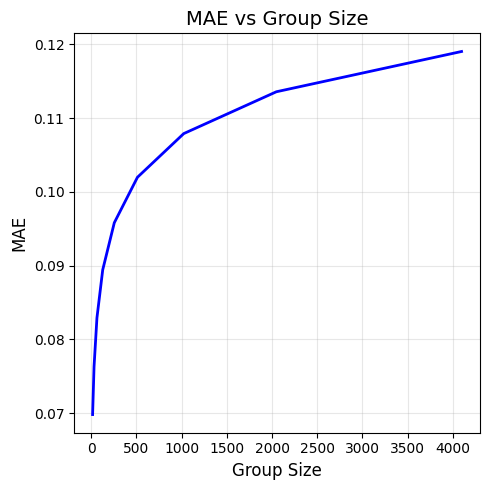

In [11]:
plot_xy(list(results.keys()), [x["MAE"] for x in results.values()], 'Group Size', 'MAE', 'MAE vs Group Size')

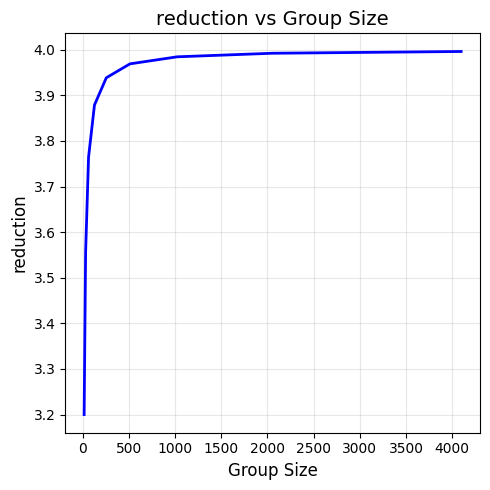

In [12]:
plot_xy(list(results.keys()), [x["reduction"] for x in results.values()], 'Group Size', 'reduction', 'reduction vs Group Size')